In [1]:
# -------------------------------------------------------------------------------------- #
# ---------- DISCRETE DIPOLE METHOD FOR UV-VIS CALCULATIONS FROM DIPOLE DATA ----------- #
# -------------------------------------------------------------------------------------- #
import fresnel
import os
import json
import pathlib
import numpy as np
import pandas as pd
from dda import DDA
from multiprocessing import Process
import tensorflow as tf
from matplotlib import pyplot as plt
import scipy.signal as signal
import scipy
def delete_1D(new_position,position):
    A=np.array(np.around(new_position,7)).tolist()
    B=np.array(np.around(position,7)).tolist()
    A = [i for i in A if i not in B]
    return A

In [2]:
# GPU Device Config
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="3"
current_folder_path = pathlib.Path().absolute()

In [3]:
# Define the overall dipole set 
position = []
for x in range(-30,30):
    for y in range(-30,30):
        for z in range(-30,30):
            if abs(x)+abs(y)+abs(z)<=20*np.sqrt(2)/2:
                position.append([x,y,z])
position = np.array(position)
scene = fresnel.Scene()
geometry = fresnel.geometry.Sphere(scene, N=len(position), radius=1.0)
geometry.position[:] = position
geometry.material = fresnel.material.Material(color=fresnel.color.linear([0.9, 0.714, 0.169]), roughness = 0.2)
fresnel.preview(scene)
np.savetxt('./data_Au@Ag_Octahedra/octahedra_overall.csv',position,delimiter=',')

In [4]:
# Define the core 
position_core = []
for x in range(-30,30):
    for y in range(-30,30):
        for z in range(-30,30):
            if abs(x)+abs(y)+abs(z)<=20*np.sqrt(2)/2*0.95:
                position_core.append([x,y,z])
position_core = np.array(position_core)

scene = fresnel.Scene()
geometry = fresnel.geometry.Sphere(scene, N=len(position_core), radius=1.0)
geometry.position[:] = position_core
geometry.material = fresnel.material.Material(color=fresnel.color.linear([0.9, 0.714, 0.169]), roughness = 0.2)
fresnel.preview(scene)
np.savetxt('./data_Au@Ag_Octahedra/octahedra_core.csv',position_core,delimiter=',')

# Randomly delete Ag dipoles

In [ ]:
for random_seed in range(10):
    extra_dipole = np.array(delete_1D(position,position_core))
    extra_index = [position.tolist().index(extra_dipole[i].tolist()) for i in range(len(extra_dipole))]
    np.random.seed(random_seed)
    np.random.shuffle(extra_index)
    np.savetxt('./data_Au@Ag_Octahedra/exp1/random_delete_sequence_%d.csv'%random_seed,extra_index,delimiter=',')

In [ ]:
for random_seed in range(10):
    extra_dipole = np.array(delete_1D(position,position_core))
    extra_index = [position.tolist().index(extra_dipole[i].tolist()) for i in range(len(extra_dipole))]
    np.random.seed(random_seed)
    np.random.shuffle(extra_index)
    # Generate the Au@Ag core shell structure
    components = np.array([1.0,0.0]).reshape(-1,1).repeat(len(position),axis=1)
    for i in extra_index:
        components[:,i] = np.array([0,1]).T
    np.savetxt(str(current_folder_path)+'/core_shell_components.csv',components,delimiter=',')
    # define the intial and final dipole sets
    config = {'gpu_device': '/GPU:0',
                'dipole_length': 1.0,
                'min_wavelength': 0.4,
                'max_wavelength': 0.9,
                'num_wavelengths': 51,
                'ref_medium': 1.333,
                'rotation_steps': 10,
                'folder_path': None,
                'calculate_electricField': False,
                'ref_data': [str(current_folder_path) + '/Au_ref_index.csv',str(current_folder_path) + '/Ag_ref_index.csv'],
                'metals': ["Au","Ag"],
                'dipole_data': str(current_folder_path) + '/data_Au@Ag_Octahedra/octahedra_overall.csv',
                "lattice_constant":0.41,
                "method":"heter_custom",
                "custom_ratio_path":str(current_folder_path)+'/core_shell_components.csv',
                'atom_data': None,
               }
    config['folder_path'] = str(current_folder_path) + '/data_Au@Ag_Octahedra/exp1/'
    with open(config['folder_path']+'/config.json','w') as outfile:
        json.dump(config,outfile)
    np_dda = DDA(config)
    alpha_j1 = np.array([np.repeat(np_dda.alpha_j[:,i],3) for i in range(np_dda.alpha_j.shape[1])]).T
    alpha_j2 = np.array([np.repeat(np_dda.alpha_j[:,i],3)/(10**10) for i in range(np_dda.alpha_j.shape[1])]).T
    atom_index = [[i for i in range(3*j,3*j+3)] for j in extra_index]
    atom_index = np.array(atom_index).flatten().tolist()
    np_dda.flip_infor = [atom_index,alpha_j1,alpha_j2]
    np_dda.calculate_spectrum_trajectories_v2()

# Delete Ag dipoles from center

In [11]:
extra_dipole = np.array(delete_1D(position,position_core))
extra_index = [position.tolist().index(extra_dipole[i].tolist()) for i in range(len(extra_dipole))]
np.random.seed(100)
np.random.shuffle(extra_index)

In [12]:
B = np.array([0,0,0])
C = np.array([1,1,1])
BC = C-B
BA = abs(position[extra_index]) - B
distance = np.linalg.norm(np.cross(BA,BC),axis=1)/np.linalg.norm(BC)
sort_arg = np.argsort(distance)
extra_index = (np.array(extra_index)[sort_arg]).tolist()
np.savetxt('./data_Au@Ag_Octahedra/exp1/from_center_delete_sequence.csv',extra_index,delimiter=',')

In [7]:
# Generate the Au@Ag core shell structure
components = np.array([1.0,0.0]).reshape(-1,1).repeat(len(position),axis=1)
for i in extra_index:
    components[:,i] = np.array([0,1]).T
np.savetxt(str(current_folder_path)+'/core_shell_components.csv',components,delimiter=',')

In [10]:
# define the intial and final dipole sets
config = {'gpu_device': '/GPU:0',
            'dipole_length': 1.0,
            'min_wavelength': 0.4,
            'max_wavelength': 0.9,
            'num_wavelengths': 51,
            'ref_medium': 1.333,
            'rotation_steps': 10,
            'folder_path': None,
            'calculate_electricField': False,
            'ref_data': [str(current_folder_path) + '/Au_ref_index.csv',str(current_folder_path) + '/Ag_ref_index.csv'],
            'metals': ["Au","Ag"],
            'dipole_data': str(current_folder_path) + '/data_Au@Ag_Octahedra/octahedra_overall.csv',
            "lattice_constant":0.41,
            "method":"heter_custom",
            "custom_ratio_path":str(current_folder_path)+'/core_shell_components.csv',
            'atom_data': None,
           }
config['folder_path'] = str(current_folder_path) + '/data_Au@Ag_Octahedra/exp1/'
with open(config['folder_path']+'/config.json','w') as outfile:
    json.dump(config,outfile)
np_dda = DDA(config)

Reading refractive index and dipole data
Calculating radius of the cross section and polarizability


In [ ]:
alpha_j1 = np.array([np.repeat(np_dda.alpha_j[:,i],3) for i in range(np_dda.alpha_j.shape[1])]).T
alpha_j2 = np.array([np.repeat(np_dda.alpha_j[:,i],3)/(10**10) for i in range(np_dda.alpha_j.shape[1])]).T
atom_index = [[i for i in range(3*j,3*j+3)] for j in extra_index]
atom_index = np.array(atom_index).flatten().tolist()
np_dda.flip_infor = [atom_index,alpha_j1,alpha_j2]
np_dda.calculate_spectrum_trajectories_v2()
data = np.array(np_dda.C_cross_total)
np.savetxt(config['folder_path']+'/data_random_from_center_seed_100.csv',data,delimiter=',')

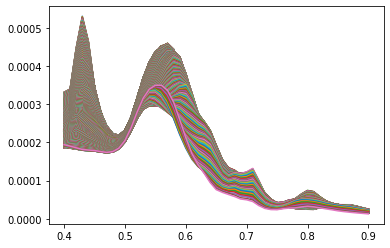

In [44]:
data = np.loadtxt('./data_Au@Ag_Octahedra/exp1/data_random_from_center_seed_100.csv',delimiter=',')
for i in range(len(data.T)):
    plt.plot(np.linspace(0.4,0.9,51),data[:,i])

# Delete dipoles from the edges

In [9]:
extra_dipole = np.array(delete_1D(position,position_core))
extra_index = [position.tolist().index(extra_dipole[i].tolist()) for i in range(len(extra_dipole))]
np.random.seed(100)
np.random.shuffle(extra_index)

In [10]:
B = np.array([0,0,0])
C = np.array([1,1,1])
BC = C-B
BA = abs(position[extra_index]) - B
distance = np.linalg.norm(np.cross(BA,BC),axis=1)/np.linalg.norm(BC)
sort_arg = np.argsort(distance)[::-1]
extra_index = (np.array(extra_index)[sort_arg]).tolist()
np.savetxt('./data_Au@Ag_Octahedra/exp1/from_edge_delete_sequence.csv',extra_index,delimiter=',')

In [44]:
# Generate the Au@Ag core shell structure
components = np.array([1.0,0.0]).reshape(-1,1).repeat(len(position),axis=1)
for i in extra_index:
    components[:,i] = np.array([0,1]).T
np.savetxt(str(current_folder_path)+'/core_shell_components.csv',components,delimiter=',')

In [10]:
# define the intial and final dipole sets
config = {'gpu_device': '/GPU:0',
            'dipole_length': 1.0,
            'min_wavelength': 0.4,
            'max_wavelength': 0.9,
            'num_wavelengths': 51,
            'ref_medium': 1.333,
            'rotation_steps': 10,
            'folder_path': None,
            'calculate_electricField': False,
            'ref_data': [str(current_folder_path) + '/Au_ref_index.csv',str(current_folder_path) + '/Ag_ref_index.csv'],
            'metals': ["Au","Ag"],
            'dipole_data': str(current_folder_path) + '/data_Au@Ag_Octahedra/octahedra_overall.csv',
            "lattice_constant":0.41,
            "method":"heter_custom",
            "custom_ratio_path":str(current_folder_path)+'/core_shell_components.csv',
            'atom_data': None,
           }
config['folder_path'] = str(current_folder_path) + '/data_Au@Ag_Octahedra/exp1/'
with open(config['folder_path']+'/config.json','w') as outfile:
    json.dump(config,outfile)
np_dda = DDA(config)

Reading refractive index and dipole data
Calculating radius of the cross section and polarizability


In [11]:
alpha_j1 = np.array([np.repeat(np_dda.alpha_j[:,i],3) for i in range(np_dda.alpha_j.shape[1])]).T
alpha_j2 = np.array([np.repeat(np_dda.alpha_j[:,i],3)/(10**10) for i in range(np_dda.alpha_j.shape[1])]).T
atom_index = [[i for i in range(3*j,3*j+3)] for j in extra_index]
atom_index = np.array(atom_index).flatten().tolist()
np_dda.flip_infor = [atom_index,alpha_j1,alpha_j2]
np_dda.calculate_spectrum_trajectories_v2()
data = np.array(np_dda.C_cross_total)
np.savetxt(config['folder_path']+'/data_random_from_edge_seed_100.csv',data,delimiter=',')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


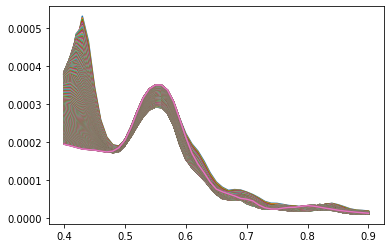

In [13]:
data = np.loadtxt('./data_Au@Ag_Octahedra/exp1/data_random_from_edge_seed_100.csv',delimiter=',')
for i in range(len(data.T)):
    plt.plot(np.linspace(0.4,0.9,51),data[:,i])

# Analysis data

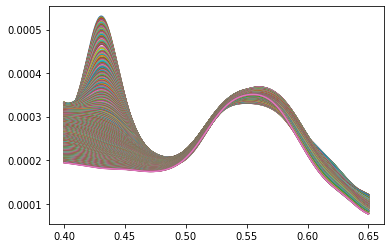

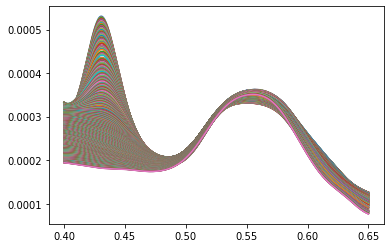

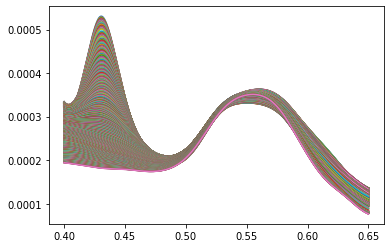

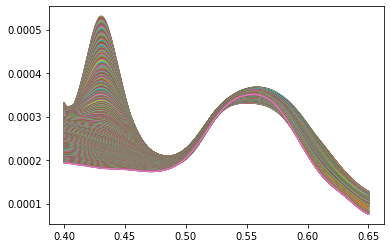

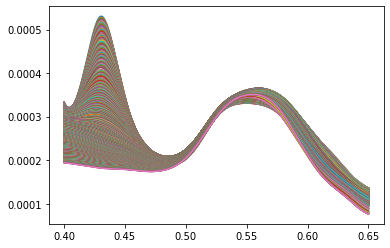

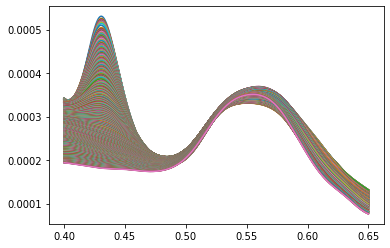

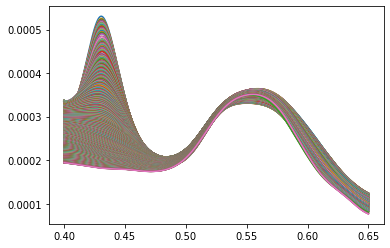

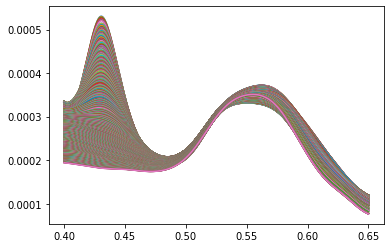

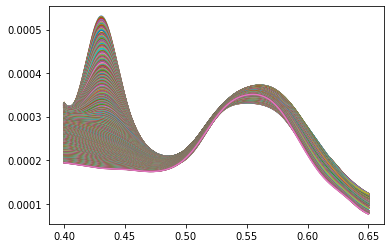

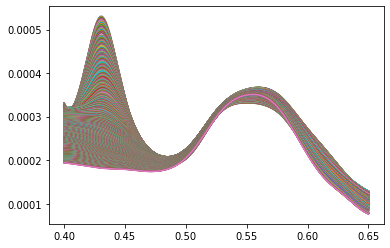

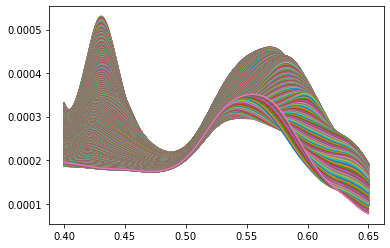

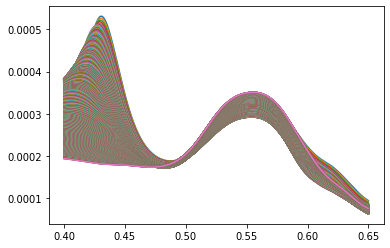

In [37]:
peak_infor = []
wavelength =np.linspace(0.4,0.9,51)[0:26]
for random_seed in range(10):
    plt.figure()
    data = np.loadtxt('./data_Au@Ag_Octahedra/exp1/data_random_seed_%d.csv'%random_seed,delimiter=',')[0:26]
    peak_infor_temp = []
    for i in range(len(data.T)):
        f = scipy.interpolate.CubicSpline(wavelength,data[:,i])
        datatest = f(np.linspace(0.4,0.65,1000))
        peak_index,_ = signal.find_peaks(datatest)
        peak_index = peak_index[np.linspace(0.4,0.65,1000)[peak_index]<0.65]
        prominence,_,__ = signal.peak_prominences(datatest,peak_index)
        peak_infor_temp.append([peak_index,prominence])
        plt.plot(np.linspace(0.4,0.65,1000),datatest)
    peak_infor.append(peak_infor_temp)
    plt.show()
    
plt.figure()
data = np.loadtxt('./data_Au@Ag_Octahedra/exp1/data_random_from_center_seed_100.csv',delimiter=',')[0:26]
peak_infor_temp = []
for i in range(len(data.T)):
    f = scipy.interpolate.CubicSpline(wavelength,data[:,i])
    datatest = f(np.linspace(0.4,0.65,1000))
    peak_index,_ = signal.find_peaks(datatest)
    peak_index = peak_index[np.linspace(0.4,0.65,1000)[peak_index]<0.65]
    prominence,_,__ = signal.peak_prominences(datatest,peak_index)
    peak_infor_temp.append([peak_index,prominence])
    plt.plot(np.linspace(0.4,0.65,1000),datatest)
peak_infor.append(peak_infor_temp)
plt.show()

plt.figure()
data = np.loadtxt('./data_Au@Ag_Octahedra/exp1/data_random_from_edge_seed_100.csv',delimiter=',')[0:26]
peak_infor_temp = []
for i in range(len(data.T)):
    f = scipy.interpolate.CubicSpline(wavelength,data[:,i])
    datatest = f(np.linspace(0.4,0.65,1000))
    peak_index,_ = signal.find_peaks(datatest)
    peak_index = peak_index[np.linspace(0.4,0.65,1000)[peak_index]<0.65]
    prominence,_,__ = signal.peak_prominences(datatest,peak_index)
    peak_infor_temp.append([peak_index,prominence])
    plt.plot(np.linspace(0.4,0.65,1000),datatest)
peak_infor.append(peak_infor_temp)
plt.show()

In [38]:
ratio_total = []
for repeat in range(12):
    ratio = []
    for i in range(len(peak_infor[repeat])):
        if len(peak_infor[repeat][i][1]) == 2:
            ratio.append(peak_infor[repeat][i][1][0]/peak_infor[repeat][i][1][1])
        elif len(peak_infor[repeat][i][1]) == 3:
            ratio.append(peak_infor[repeat][i][1][0]/max(peak_infor[repeat][i][1][1],peak_infor[repeat][i][1][2]))
        elif len(peak_infor[repeat][i][1]) == 4:
            ratio.append(peak_infor[repeat][i][1][0]/max(peak_infor[repeat][i][1][1],peak_infor[repeat][i][1][2]),peak_infor[repeat][i][1][3])
        else:
            ratio.append(0)
        print(peak_infor[repeat][i])
    ratio_total.append(ratio)

[array([122, 601]), array([0.00021451, 0.00014294])]
[array([122, 599]), array([0.00021064, 0.00014247])]
[array([122, 600]), array([0.0002094 , 0.00014222])]
[array([122, 599]), array([0.00020839, 0.0001423 ])]
[array([123, 599]), array([0.00020569, 0.00014194])]
[array([123, 599]), array([0.0002048 , 0.00014202])]
[array([123, 599]), array([0.0002022 , 0.00014166])]
[array([123, 600]), array([0.00020104, 0.00014175])]
[array([123, 599]), array([0.00020003, 0.00014184])]
[array([123, 600]), array([0.00019845, 0.00014188])]
[array([123, 600]), array([0.00019669, 0.00014171])]
[array([123, 600]), array([0.00019575, 0.00014179])]
[array([123, 599]), array([0.0001948 , 0.00014186])]
[array([123, 600]), array([0.00019375, 0.00014155])]
[array([123, 600]), array([0.00019265, 0.00014161])]
[array([122, 599]), array([0.00019158, 0.00014175])]
[array([122, 600]), array([0.00019041, 0.00014147])]
[array([122, 601]), array([0.00018939, 0.00014167])]
[array([122, 602]), array([0.00018707, 0.00014

[array([623]), array([0.00015071])]
[array([623]), array([0.00015088])]
[array([623]), array([0.00015112])]
[array([623]), array([0.00015124])]
[array([623]), array([0.00015125])]
[array([623]), array([0.00015149])]
[array([624]), array([0.00015145])]
[array([624]), array([0.00015154])]
[array([624]), array([0.00015129])]
[array([624]), array([0.0001515])]
[array([624]), array([0.00015106])]
[array([624]), array([0.00015126])]
[array([625]), array([0.00015133])]
[array([625]), array([0.00015148])]
[array([625]), array([0.00015171])]
[array([626]), array([0.00015152])]
[array([626]), array([0.00015207])]
[array([625]), array([0.00015191])]
[array([626]), array([0.00015203])]
[array([625]), array([0.00015223])]
[array([625]), array([0.00015259])]
[array([626]), array([0.00015253])]
[array([626]), array([0.00015272])]
[array([626]), array([0.00015306])]
[array([626]), array([0.00015332])]
[array([626]), array([0.00015319])]
[array([626]), array([0.00015315])]
[array([626]), array([0.00015

[array([629]), array([0.00015943])]
[array([628]), array([0.00015982])]
[array([629]), array([0.00016003])]
[array([628]), array([0.00015948])]
[array([628]), array([0.00015957])]
[array([628]), array([0.00015969])]
[array([628]), array([0.00015921])]
[array([628]), array([0.00015941])]
[array([628]), array([0.00015956])]
[array([628]), array([0.00015937])]
[array([626]), array([0.00015909])]
[array([627]), array([0.00015927])]
[array([626]), array([0.00015936])]
[array([626]), array([0.00015951])]
[array([626]), array([0.00015916])]
[array([626]), array([0.0001594])]
[array([626]), array([0.00015981])]
[array([627]), array([0.00015922])]
[array([627]), array([0.00015932])]
[array([627]), array([0.00015918])]
[array([627]), array([0.00015965])]
[array([627]), array([0.00015959])]
[array([628]), array([0.00015955])]
[array([627]), array([0.00015977])]
[array([627]), array([0.00015989])]
[array([628]), array([0.00016069])]
[array([628]), array([0.00016095])]
[array([628]), array([0.00016

[array([635]), array([0.00017211])]
[array([635]), array([0.00017207])]
[array([636]), array([0.00017226])]
[array([634]), array([0.00017136])]
[array([634]), array([0.00017155])]
[array([634]), array([0.0001709])]
[array([635]), array([0.00017111])]
[array([635]), array([0.00017121])]
[array([635]), array([0.00017145])]
[array([635]), array([0.00017173])]
[array([635]), array([0.00017178])]
[array([634]), array([0.00017171])]
[array([634]), array([0.00017119])]
[array([635]), array([0.00017106])]
[array([633]), array([0.00017054])]
[array([633]), array([0.00017065])]
[array([633]), array([0.00017075])]
[array([  1, 633]), array([1.78259052e-09, 1.70870321e-04])]
[array([633]), array([0.0001704])]
[array([633]), array([0.00017051])]
[array([633]), array([0.00017066])]
[array([633]), array([0.00017071])]
[array([633]), array([0.00017104])]
[array([633]), array([0.00017049])]
[array([634]), array([0.00017284])]
[array([634]), array([0.00017294])]
[array([633]), array([0.00017263])]
[arra

[array([  7, 612]), array([5.35496721e-08, 1.68655649e-04])]
[array([  6, 612]), array([4.18551165e-08, 1.68706739e-04])]
[array([  7, 612]), array([4.63708091e-08, 1.68857614e-04])]
[array([  6, 612]), array([3.58954740e-08, 1.68918487e-04])]
[array([  6, 611]), array([2.97269705e-08, 1.68647332e-04])]
[array([  3, 609]), array([1.14365191e-08, 1.68310953e-04])]
[array([  5, 609]), array([1.97101546e-08, 1.68237423e-04])]
[array([  1, 608]), array([7.14709078e-10, 1.67885971e-04])]
[array([608]), array([0.00016774])]
[array([608]), array([0.00016773])]
[array([608]), array([0.00016775])]
[array([608]), array([0.00016765])]
[array([607]), array([0.00016765])]
[array([607]), array([0.00016783])]
[array([605]), array([0.00016838])]
[array([605]), array([0.00016822])]
[array([605]), array([0.00016823])]
[array([605]), array([0.00016821])]
[array([605]), array([0.00016836])]
[array([605]), array([0.00016834])]
[array([604]), array([0.00016812])]
[array([606]), array([0.00017052])]
[array([

[array([121, 612]), array([8.24961096e-05, 1.40825044e-04])]
[array([121, 612]), array([8.24538900e-05, 1.41124144e-04])]
[array([121, 613]), array([8.14252302e-05, 1.41265309e-04])]
[array([121, 612]), array([8.08393275e-05, 1.41324611e-04])]
[array([121, 612]), array([8.02537376e-05, 1.41467493e-04])]
[array([121, 612]), array([7.94933816e-05, 1.41201372e-04])]
[array([122, 613]), array([7.96306637e-05, 1.40897599e-04])]
[array([121, 613]), array([7.85656239e-05, 1.41196520e-04])]
[array([122, 614]), array([7.67967672e-05, 1.40896383e-04])]
[array([122, 613]), array([7.63112554e-05, 1.41063016e-04])]
[array([121, 613]), array([7.56034313e-05, 1.41313879e-04])]
[array([121, 613]), array([7.52237242e-05, 1.41658367e-04])]
[array([121, 613]), array([7.46463518e-05, 1.41763061e-04])]
[array([121, 613]), array([7.43488222e-05, 1.41833946e-04])]
[array([121, 613]), array([7.34863132e-05, 1.42238931e-04])]
[array([121, 613]), array([7.24648551e-05, 1.41869170e-04])]
[array([121, 614]), arra

[array([116, 628]), array([2.09857084e-05, 1.49976432e-04])]
[array([116, 628]), array([2.07425602e-05, 1.50232145e-04])]
[array([116, 629]), array([2.03625468e-05, 1.50387249e-04])]
[array([116, 629]), array([1.97640295e-05, 1.50444928e-04])]
[array([116, 629]), array([1.99430178e-05, 1.50581850e-04])]
[array([116, 629]), array([2.01538109e-05, 1.50587783e-04])]
[array([116, 630]), array([1.98633664e-05, 1.51008349e-04])]
[array([116, 630]), array([1.90022270e-05, 1.50548005e-04])]
[array([116, 629]), array([1.87188413e-05, 1.50752218e-04])]
[array([116, 630]), array([1.87115160e-05, 1.50727114e-04])]
[array([115, 630]), array([1.79933166e-05, 1.50983359e-04])]
[array([115, 631]), array([1.78161152e-05, 1.51130663e-04])]
[array([115, 632]), array([1.70565138e-05, 1.51054016e-04])]
[array([115, 632]), array([1.70002703e-05, 1.51256139e-04])]
[array([115, 632]), array([1.67996294e-05, 1.51361056e-04])]
[array([115, 631]), array([1.71098941e-05, 1.51013522e-04])]
[array([115, 631]), arra

[array([646]), array([0.00016061])]
[array([644]), array([0.00016097])]
[array([645]), array([0.00016058])]
[array([645]), array([0.00016094])]
[array([644]), array([0.00016134])]
[array([644]), array([0.00016113])]
[array([644]), array([0.00016135])]
[array([644]), array([0.00016147])]
[array([645]), array([0.00016155])]
[array([646]), array([0.00016143])]
[array([646]), array([0.00016166])]
[array([646]), array([0.00016176])]
[array([646]), array([0.00016215])]
[array([646]), array([0.00016236])]
[array([645]), array([0.00016232])]
[array([644]), array([0.00016159])]
[array([644]), array([0.00016172])]
[array([644]), array([0.00016183])]
[array([644]), array([0.00016197])]
[array([644]), array([0.00016202])]
[array([644]), array([0.00016207])]
[array([643]), array([0.0001617])]
[array([642]), array([0.00016191])]
[array([643]), array([0.00016201])]
[array([643]), array([0.00016219])]
[array([643]), array([0.0001624])]
[array([643]), array([0.00016246])]
[array([642]), array([0.000161

[array([632]), array([0.00016095])]
[array([632]), array([0.00016131])]
[array([631]), array([0.00016075])]
[array([632]), array([0.0001609])]
[array([632]), array([0.00016102])]
[array([632]), array([0.00016114])]
[array([632]), array([0.00016127])]
[array([632]), array([0.0001614])]
[array([631]), array([0.00016117])]
[array([631]), array([0.00016117])]
[array([631]), array([0.00016131])]
[array([632]), array([0.00016143])]
[array([632]), array([0.00016155])]
[array([632]), array([0.00016156])]
[array([632]), array([0.00016156])]
[array([632]), array([0.00016165])]
[array([632]), array([0.00016137])]
[array([632]), array([0.00016069])]
[array([631]), array([0.00016038])]
[array([629]), array([0.00016042])]
[array([630]), array([0.00016046])]
[array([630]), array([0.00016007])]
[array([630]), array([0.00016029])]
[array([631]), array([0.00016052])]
[array([632]), array([0.00016075])]
[array([632]), array([0.00016096])]
[array([629]), array([0.00016041])]
[array([630]), array([0.000159

[array([ 83, 725]), array([2.07975527e-05, 2.47890836e-04])]
[array([ 83, 725]), array([2.04583308e-05, 2.47603667e-04])]
[array([ 82, 725]), array([2.00883944e-05, 2.47244528e-04])]
[array([ 82, 725]), array([1.97630788e-05, 2.46941172e-04])]
[array([ 82, 725]), array([1.94043918e-05, 2.46582652e-04])]
[array([ 81, 725]), array([1.90910137e-05, 2.46307113e-04])]
[array([ 81, 726]), array([1.87852183e-05, 2.46011400e-04])]
[array([ 81, 726]), array([1.84350454e-05, 2.45676729e-04])]
[array([ 80, 726]), array([1.81705934e-05, 2.45423677e-04])]
[array([ 80, 726]), array([1.79234587e-05, 2.45180589e-04])]
[array([ 80, 726]), array([1.76892918e-05, 2.44984502e-04])]
[array([ 79, 727]), array([1.74508380e-05, 2.44718648e-04])]
[array([ 79, 727]), array([1.71673067e-05, 2.44371123e-04])]
[array([ 79, 727]), array([1.69235199e-05, 2.44058978e-04])]
[array([ 78, 727]), array([1.66889035e-05, 2.43784444e-04])]
[array([ 78, 727]), array([1.65152091e-05, 2.43571901e-04])]
[array([ 77, 727]), arra

[array([616]), array([0.00016476])]
[array([616]), array([0.00016492])]
[array([617]), array([0.0001651])]
[array([617]), array([0.00016525])]
[array([617]), array([0.00016543])]
[array([617]), array([0.00016564])]
[array([617]), array([0.00016581])]
[array([617]), array([0.000166])]
[array([618]), array([0.00016619])]
[array([618]), array([0.00016637])]
[array([618]), array([0.00016655])]
[array([618]), array([0.0001667])]
[array([618]), array([0.0001669])]
[array([619]), array([0.00016709])]
[array([619]), array([0.00016728])]
[array([619]), array([0.00016746])]
[array([619]), array([0.00016763])]
[array([619]), array([0.00016785])]
[array([619]), array([0.00016804])]
[array([620]), array([0.00016823])]
[array([620]), array([0.00016843])]
[array([620]), array([0.00016861])]
[array([620]), array([0.0001688])]
[array([620]), array([0.00016897])]
[array([620]), array([0.00016917])]
[array([621]), array([0.00016935])]
[array([621]), array([0.00016954])]
[array([621]), array([0.00016973])

In [42]:
peak_prominences = []
for repeat in range(12):
    peak_prominences_temp = []
    for i in range(len(peak_infor[repeat])):
        if len(peak_infor[repeat][i][1]) == 2:
            peak_prominences_temp.append([peak_infor[repeat][i][1][0],peak_infor[repeat][i][1][1]])
        elif len(peak_infor[repeat][i][1]) == 3:
            peak_prominences_temp.append([peak_infor[repeat][i][1][0],max(peak_infor[repeat][i][1][1],peak_infor[repeat][i][1][2])])
        else:
            peak_prominences_temp.append([peak_infor[repeat][i][1][0]])
    peak_prominences.append(peak_prominences_temp)

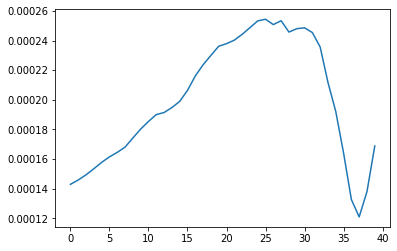

In [43]:
plt.plot([peak_prominences[-2][i][-1] for i in range(0,len(peak_prominences[-2]),20)])

Text(0, 0.5, 'Ag feature/Au feature')

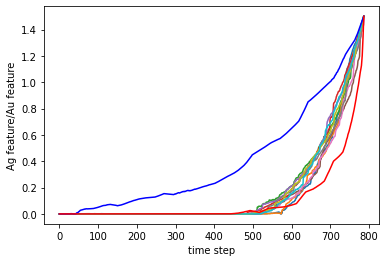

In [44]:
for i in range(10):
    plt.plot(ratio_total[i][::-1])
    
plt.plot(ratio_total[10][::-1],c = 'blue')
plt.plot(ratio_total[11][::-1],c = 'red')
plt.xlabel('time step')
plt.ylabel('Ag feature/Au feature')

In [45]:
np.savetxt('ratioes.csv',np.array(ratio_total),delimiter=',')